#Natural Language Processing Project

##Part A

To build a NLP classifier which can use input text parameters to determine the label/s of the blog. Specific to this case
study, you can consider the text of the blog: ‘text’ feature as independent variable and ‘topic’ as dependent variable.

**Importing modules for project**

In [1]:
# Import Libraries

import os
import sys
import warnings                                 # `dnd` mode
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


import seaborn as sns
import matplotlib as plt
%matplotlib inline

In [2]:
from google.colab import drive #mounting drive
drive.mount('/content/drive')

Mounted at /content/drive


**Read and Analyse Dataset**

A. Clearly write outcome of data analysis(Minimum 2 points)

B. Clean the Structured Data

In [3]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/nlp1 project/blogtext.csv")

In [4]:
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [5]:
df.shape

(681284, 7)

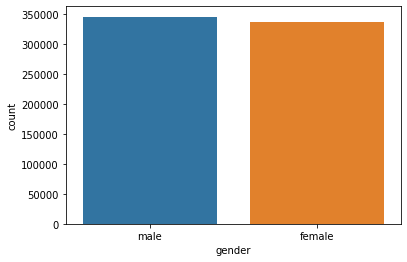

In [6]:
#Check gender-wise distribution
sns.countplot(x='gender',data=df);

genderwise distrubution shows there is no bias to any gender

In [7]:
df1 = pd.read_csv("drive/My Drive/Colab Notebooks/nlp1 project/blogtext.csv",nrows=100000)

missing value imputation

In [8]:
df1.isnull().sum() # check for null values

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [9]:
df1.nunique() # check for unique values

id         2768
gender        2
age          26
topic        40
sign         12
date       1564
text      97566
dtype: int64

there are duplicate records in text column we will check the same

In [10]:
df1[["text"]].duplicated().sum() # duplicate texts

2434

In [11]:
df1[["id","text"]].duplicated().sum() # duplicate per blogger

1232

In [12]:
df1.duplicated().sum() # overall duplicates


836

In [13]:
df1.loc[df1["text"]==df1.loc[df1[["id","text"]].duplicated(),"text"].values[10]] # random duplicate review

,id,gender,age,topic,sign,date,text
3828,3543234,male,14,indUnk,Scorpio,"07,June,2004",ZmX: I hate these geek 20 year olds...
3829,3543234,male,14,indUnk,Scorpio,"07,June,2004",ZmX: I hate these geek 20 year olds...


In [14]:
df1.drop(df1.loc[df1.duplicated()].index)[["id","text"]].duplicated().sum() 
# overall duplicates dropped, review duplicate per blogger

396

In [15]:
df1.drop(df1.loc[df1.duplicated()].index)[["id","date","text"]].duplicated().sum() 
# overall duplicates dropped, review duplicate per blogger on the same date

0

In [16]:
df2 = df1.drop(df1.loc[df1.duplicated()].index)
df2.loc[df2["text"]==np.sort(df2.loc[df2[["id","text"]].duplicated(),"text"].values)[-5]] # random duplicate review

,id,gender,age,topic,sign,date,text
80735,3023198,male,26,Banking,Taurus,"21,July,2004",Will post more details soon...
80737,3023198,male,26,Banking,Taurus,"19,July,2004",Will post more details soon...
80738,3023198,male,26,Banking,Taurus,"18,July,2004",Will post more details soon...
80740,3023198,male,26,Banking,Taurus,"16,July,2004",Will post more details soon...
80741,3023198,male,26,Banking,Taurus,"15,July,2004",Will post more details soon...
80742,3023198,male,26,Banking,Taurus,"14,July,2004",Will post more details soon...


In [17]:
np.sort(df2.loc[df2[["id","text"]].duplicated(),"text"].values) # duplicate texts review

array(['    ', '    ', '    ', '    ', '       ', '        ',
       '           ', '           ', '           ', '           ',
       '           ', '            ', '            ', '            ',
       '            ', '            ', '            ', '            ',
       '            ', '            ', '            ', '            ',
       '            ', '            ', '             ', '             ',
       '             ', '             ', '              ',
       '               ', '                ', '                ',
       '                ', '                ', '                 ',
       '                 ', '                 ', '                 ',
       '                 ', '                 ', '                 ',
       '                 ', '                 ', '                 ',
       '                 ', '                  ', '                    ',
       '                    ', '                    ',
       '                    ', '                    ',

the 2434 duplicate records of the complete dataset needs to be droppped without further considerations
the rest of the dupliates needs to be retained as the blogger might have share same expressions in a later date

the text needs to be filtered for blank space texts

In [18]:
# drop all-duplicates
df1.drop(df1.loc[df1.duplicated()].index,inplace=True)

Eliminate Non-English textual data

In [19]:
pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 33.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993241 sha256=c52dde2afd503243e18fa00c533844a141bcad309c1e73da27c4828448b97f7d
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [20]:
from langdetect import detect

def detect_english(text):
  try:
      return detect(text) == 'en'
  except:
      return False

In [21]:
df3 =df1.copy()
df3 = df3[df3['text'].apply(detect_english)]

In [22]:
df3.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...


In [23]:
df3.shape

(95013, 7)

**Preprocess unstructured data to make it consumable for model training.**

A. Eliminate All special Characters and Numbers

B. Lowercase all textual data

C. Remove all Stopwords 

D. Remove all extra white spaces

In [24]:
# review all other unique values
for col in ["gender","age","topic","sign"]:
    print(col,":",np.sort(df3[col].unique()))

gender : ['female' 'male']
age : [13 14 15 16 17 23 24 25 26 27 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48]
topic : ['Accounting' 'Advertising' 'Agriculture' 'Architecture' 'Arts'
 'Automotive' 'Banking' 'Biotech' 'BusinessServices' 'Chemicals'
 'Communications-Media' 'Construction' 'Consulting' 'Education'
 'Engineering' 'Environment' 'Fashion' 'Government' 'HumanResources'
 'Internet' 'InvestmentBanking' 'Law' 'LawEnforcement-Security'
 'Manufacturing' 'Maritime' 'Marketing' 'Military' 'Museums-Libraries'
 'Non-Profit' 'Publishing' 'RealEstate' 'Religion' 'Science'
 'Sports-Recreation' 'Student' 'Technology' 'Telecommunications' 'Tourism'
 'Transportation' 'indUnk']
sign : ['Aquarius' 'Aries' 'Cancer' 'Capricorn' 'Gemini' 'Leo' 'Libra' 'Pisces'
 'Sagittarius' 'Scorpio' 'Taurus' 'Virgo']


In [25]:
# number of records with IndustryUnknown
len(df3.loc[df3["topic"]=="indUnk"])

31362

In [26]:
# drop all-duplicates
df3.drop(df3.loc[df3.duplicated()].index,inplace=True)
# drop indUnk
df3.drop(df3.loc[df["topic"]=="indUnk"].index,inplace=True)
# drop any blank text records
df3.drop(df3.loc[df["text"]==''].index,inplace=True)

In [27]:
# review output shape
df3.shape

(63651, 7)

In [28]:
#Importing re library for Regular Expression Engine
import re

#Importing stopwords sub-module from module corpus in nltk library
from nltk.corpus import stopwords

#Lower casing & stripping
df3['text'] =df3['text'].apply(lambda s: s.lower().strip())

#Printing top 5 records to check if the Dataset is loaded properly
df3.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","info has been found (+/- 100 pages, and 4.5 mb..."
2,2059027,male,15,Student,Leo,"12,May,2004",in het kader van kernfusie op aarde: maak je ...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks to yahoo!'s toolbar i can now 'capture'...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",i had an interesting conversation with my dad ...


In [29]:
#Keeping only Alphanumeric values & spaces
df3['text'] = df3['text'].apply(lambda s: re.sub('[^a-z ]+',' ',s))

#Printing top 5 records to check if the Dataset is loaded properly
df3.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",info has been found pages and mb of pd...
2,2059027,male,15,Student,Leo,"12,May,2004",in het kader van kernfusie op aarde maak je ...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks to yahoo s toolbar i can now capture ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",i had an interesting conversation with my dad ...


In [30]:
import nltk
nltk.download('stopwords')
#set of stop words
stop_words = set(stopwords.words('english'))

#For each stop-words, replace them by spaces in the text column of he Dataset
for w in stop_words:
   df3['text'] =df3['text'].apply(lambda s: re.sub('(^|[ ]+)' + w + '([ ]+|$)',' ',s))

#Printing top 5 records to check if the Dataset is loaded properly
df3.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",info found pages mb pdf files wait untill ...
2,2059027,male,15,Student,Leo,"12,May,2004",het kader van kernfusie op aarde maak je ei...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks yahoo toolbar capture urls popups means...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",interesting conversation dad morning talking ...


In [31]:
#Removing unwanted spaces
df3['text'] = df3['text'].apply(lambda s: re.sub('[ ]{2,}',' ',s))
df3['text'] = df3['text'].apply(lambda s: re.sub('(^[ ]+|[ ]+$)','',s))

#Printing top 5 records to check if the Dataset is loaded properly
df3.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",info found pages mb pdf files wait untill team...
2,2059027,male,15,Student,Leo,"12,May,2004",het kader van kernfusie op aarde maak je eigen...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks yahoo toolbar capture urls popups means...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",interesting conversation dad morning talking k...


**Build a base Classification model**

A. Create dependent and independent variables 

B. Split data into train and test.

C. Vectorize data using any one vectorizer. 

D. Build a base model for Supervised Learning - Classification. 

E. Clearly print Performance Metrics. 

In [42]:
#Merging all the Label columns together
df3['labels'] = df3[['gender','age','topic','sign']].values.tolist()

#Printing top 5 records to check if the Dataset is loaded properly
df3.head()

,id,gender,age,topic,sign,date,text,labels
0,2059027,male,15,Student,Leo,"14,May,2004",info found pages mb pdf files wait untill team...,"[male, 15, Student, Leo]"
2,2059027,male,15,Student,Leo,"12,May,2004",het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing,"[male, 15, Student, Leo]"
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks yahoo toolbar capture urls popups means...,"[male, 33, InvestmentBanking, Aquarius]"
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",interesting conversation dad morning talking k...,"[male, 33, InvestmentBanking, Aquarius]"


In [43]:
#Dropping unwanted columns from Dataset
df3.drop(columns = ['id','gender','age','topic','sign','date'], inplace=True)

#Printing top 5 records to check if the Dataset is loaded properly
df3.head()


,text,labels
0,info found pages mb pdf files wait untill team...,"[male, 15, Student, Leo]"
2,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,testing testing,"[male, 15, Student, Leo]"
4,thanks yahoo toolbar capture urls popups means...,"[male, 33, InvestmentBanking, Aquarius]"
5,interesting conversation dad morning talking k...,"[male, 33, InvestmentBanking, Aquarius]"


In [44]:
X=df3['text']
y=df3['labels']

In [45]:
#Importing train_test_split function from module model_selection in library sklearn
from sklearn.model_selection import train_test_split

#Doing a train test split with test_size of 0.20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [ ]:
X_train

41420    today marks third day work tomorrow marks last...
95978    ok day new job company little behind times sin...
87561    man last night sleep knew wake early morning r...
35213    elizabeth grudge sparrow gets uptite someone t...
62639    wasting time money great summer oh yah yesterd...
                               ...                        
39534    believe destiny see movie got tickets matrix r...
77888    sure belong nowhere home wrong sympathy goo go...
38346    graduation growing closer closer exciting nerv...
84737    coolest song urllink josh groban josh groban d...
24105    watch stupid get scared stinky poop currently ...
Name: text, Length: 50936, dtype: object

we will create bag of words using countvectorizer

In [ ]:
#Importing CountVectorizer function from feature_extraction.text submodule in sklearn library
from sklearn.feature_extraction.text import CountVectorizer

#define vectorizer parameters
vectorizer = CountVectorizer(ngram_range=(1,2))

#Creating document-term matrix
X_train_vect = vectorizer.fit_transform(X_train)

In [ ]:
#Doing transform on X_test
X_test_vect = vectorizer.transform(X_test)

In [ ]:
#Creating blank dictionary for Training Labels
label_count_train = dict()

#For each record in training labels
for record in y_train:
    #For each listitem in the record
    for label in record:
        #Checking if label is new one
        if label not in label_count_train.keys():
            #Storing new labels in dictionary and registering a count of 1
            label_count_train[str(label)] = 1
        #Else
        else:
            #Increment the count for label in dictionary
            label_count_train[str(label)] += 1
#Printing the dictionary for training set labels
print(label_count_train)

{'female': 21428, '17': 1, 'Fashion': 1476, 'Taurus': 4053, '25': 1, 'Student': 17062, '23': 1, 'Education': 4286, 'Leo': 4290, '15': 1, 'Cancer': 4571, '42': 1, 'Consulting': 668, 'male': 29508, 'Gemini': 4839, '34': 1, 'Aquarius': 4530, '24': 1, 'Technology': 6437, 'Libra': 3278, 'Capricorn': 5042, '26': 1, 'Government': 1552, 'Communications-Media': 2100, '37': 1, 'Manufacturing': 412, 'Virgo': 3990, 'Arts': 3859, '27': 1, 'Sagittarius': 2724, '16': 1, '33': 1, 'Internet': 1647, 'Publishing': 831, 'Religion': 857, '35': 1, 'Aries': 5387, '14': 1, '39': 1, 'Scorpio': 3729, '36': 1, 'Maritime': 49, 'Engineering': 1787, 'Architecture': 57, 'Agriculture': 132, 'Marketing': 540, 'Pisces': 4503, 'Military': 605, 'BusinessServices': 493, '40': 1, 'Science': 786, '45': 1, '13': 1, '41': 1, 'Sports-Recreation': 324, '46': 1, 'Non-Profit': 1036, 'LawEnforcement-Security': 290, '48': 1, 'Advertising': 530, 'Law': 278, 'Biotech': 262, 'Chemicals': 199, 'Transportation': 468, 'Automotive': 102, 

In [ ]:
#Creating blank dictionary for Testing Labels
label_count_test = dict()

#For each record in testing labels
for record in y_test:
    #For each listitem in the record
    for label in record:
        #Checking if label is new one
        if label not in label_count_test.keys():
            #Storing new labels in dictionary and registering a count of 1
            label_count_test[str(label)] = 1
        #Else
        else:
            #Increment the count for label in dictionary
            label_count_test[str(label)] += 1
#Printing the dictionary for testing set labels
print(label_count_test)

{'male': 7417, '15': 1, 'Student': 4226, 'Sagittarius': 700, 'female': 5318, '14': 1, 'Arts': 1007, 'Taurus': 981, '17': 1, 'Pisces': 1112, '16': 1, 'Leo': 1033, '40': 1, 'Communications-Media': 500, '26': 1, 'Technology': 1611, 'Scorpio': 922, 'Government': 414, '34': 1, 'Biotech': 58, 'Aries': 1382, 'Virgo': 1074, 'Capricorn': 1241, '23': 1, 'Aquarius': 1156, '35': 1, '27': 1, 'Manufacturing': 125, 'Cancer': 1132, 'Education': 1063, 'Gemini': 1208, '36': 1, 'Fashion': 358, 'Engineering': 432, 'Museums-Libraries': 60, 'Marketing': 148, 'Accounting': 82, '24': 1, 'Transportation': 129, '33': 1, 'Internet': 399, '37': 1, 'Religion': 199, 'HumanResources': 43, '25': 1, 'Banking': 67, '45': 1, 'Science': 220, '46': 1, 'Consulting': 178, '39': 1, 'BusinessServices': 109, 'Sports-Recreation': 78, 'Non-Profit': 253, '43': 1, 'Libra': 794, 'Law': 63, 'InvestmentBanking': 29, 'Advertising': 149, 'Military': 158, '41': 1, '13': 1, '47': 1, 'Architecture': 17, 'Publishing': 217, 'Construction': 

In [ ]:
#Importing MultiLabelBinarizer sub-module from preprocessing module in sklearn library
from sklearn.preprocessing import MultiLabelBinarizer

#To get rid of numbers from y_train
x = []
for i in y_train:
    l = list()
    for j in i:
        l.append(str(j))
    x.append(l)
y_train = x

#To get rid of numbers from y_test
x = []
for i in y_test:
    l = list()
    for j in i:
        l.append(str(j))
    x.append(l)
y_test = x

#Deleting temporary variable x
del x

#Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

#Fitting MultiLabelBinarizer with training Labels & transforming it to get them in One-hot encoded form
label_train = mlb.fit_transform(y_train)

#Transforming testing Labels to get them in One-hot encoded form
label_test = mlb.transform(y_test)

In [ ]:
label_train

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

n this task, we suggest using the One-vs-Rest approach, which is implemented in OneVsRestClassifier class. In this approach k classifiers (= number of tags) are trained. As a basic classifier, use LogisticRegression. It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time because the number of classifiers to train is large.

In [ ]:
#Importing OneVsRestClassfier sub-module from multiclass module in sklearn library
from sklearn.multiclass import OneVsRestClassifier

#Importing LogisticRegression sub-module from linear_model module in sklearn library
from sklearn.linear_model import LogisticRegression

#Initializing LogisticRegression model with lbfgs solver
clf = LogisticRegression(solver='lbfgs',max_iter=100)

#Wrapping it up in OneVsRestClassifier
clf = OneVsRestClassifier(clf)

In [ ]:
#Fitting the OVR model on training dataset
clf.fit(X_train_vect, label_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
#Predicting labels for training features
label_pred = clf.predict(X_test_vect)

In [ ]:
#Importing accuracy_score, f1_score, precision_score, recall_score sub-modules from metrics module in sklearn library
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#Printing Accuracy, F1, Average Precision & Average Recall using micro averaging
print('Accuracy:', accuracy_score(label_test, label_pred))
print('F1:', f1_score(label_test, label_pred, average='micro'))
print('Average Precision:', precision_score(label_test, label_pred, average='micro'))
print('Average Recall:', recall_score(label_test, label_pred, average='micro'))

Accuracy: 0.12359638790734197
F1: 0.5070374987015686
Average Precision: 0.7487728179168585
Average Recall: 0.38329407145661565


Accuracy of logistic regression is too low 

**Improve Performance of model.**

A. Experiment with other vectorisers.

B. Build classifier Models using other algorithms than base model.

C. Tune Parameters/Hyperparameters of the model/s.

D. Clearly print Performance Metrics.

In [32]:
df4= df3.copy()

In [46]:
df4

,id,gender,age,topic,sign,date,text
0,2059027,male,15,34,Leo,"14,May,2004",info found pages mb pdf files wait untill team...
2,2059027,male,15,34,Leo,"12,May,2004",het kader van kernfusie op aarde maak je eigen...
3,2059027,male,15,34,Leo,"12,May,2004",testing testing
4,3581210,male,33,20,Aquarius,"11,June,2004",thanks yahoo toolbar capture urls popups means...
5,3581210,male,33,20,Aquarius,"10,June,2004",interesting conversation dad morning talking k...
...,...,...,...,...,...,...,...
99995,1709399,male,27,34,Virgo,"18,September,2003",hindu years great see special edition hindu co...
99996,1709399,male,27,34,Virgo,"16,September,2003",dilbert iit ans global iit brand finds space u...
99997,1709399,male,27,34,Virgo,"12,September,2003",case study hp billion p g outsourcing deal bea...
99998,1709399,male,27,34,Virgo,"09,September,2003",championing chennai bangalore iim hyderabad ho...


In [47]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df4['topic']=le.fit_transform(df4['topic'])

In [48]:
df4['topic']

0        34
2        34
3        34
4        20
5        20
         ..
99995    34
99996    34
99997    34
99998    34
99999    34
Name: topic, Length: 63651, dtype: int64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df4['text'], df4['topic'], test_size=0.20)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
test_tfidf = tfidf.transform(df4['text'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(X_train_tfidf, y_train)
pldt = DT.predict(X_test_tfidf)
#pldtt = DT.predict(x)
srdt=DT.score(X_test_tfidf, y_test)
print("Accuracy of DT",srdt*100)

Accuracy of DT 33.938108702481934


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
print(rf.score(X_test_tfidf, y_test))
predictions = rf.predict(X_test_tfidf)


0.4116722959704658


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.57      0.06      0.10       139
           2       1.00      0.07      0.13        28
           3       0.00      0.00      0.00        17
           4       0.73      0.05      0.10       943
           5       0.00      0.00      0.00        18
           6       1.00      0.02      0.04        52
           7       0.50      0.02      0.04        55
           8       0.00      0.00      0.00       114
           9       1.00      0.06      0.12        47
          10       0.54      0.06      0.10       508
          11       0.00      0.00      0.00        63
          12       0.43      0.02      0.03       171
          13       0.79      0.21      0.33      1082
          14       0.47      0.03      0.06       428
          16       0.95      0.37      0.53       396
          17       0.90      0.24      0.38       392
          18       0.50    

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(120, 200, num = 20)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node


random_grid = {'n_estimators': n_estimators,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

}
rf1 = RandomForestClassifier()

In [53]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf1,

param_distributions = random_grid,
               n_iter = 100, cv = 3, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [120, 124, 128, 132, 136,
                                                      141, 145, 149, 153, 157,
                                                      162, 166, 170, 174, 178,
                                                      183, 187, 191, 195, 200],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19,
                                                         20]},
                   random_state=35, verbose=2)

In [54]:
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')
print('\n Best estimator:')
print(rf_random.best_estimator_)


Best Parameters:  {'n_estimators': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 195}  


 Best estimator:
RandomForestClassifier(max_depth=195, min_samples_split=6, n_estimators=14)


In [55]:
rf2 = RandomForestClassifier(n_estimators=14, min_samples_split= 6,min_samples_leaf=1, max_depth= 195)
rf2.fit(X_train_tfidf, y_train)
print(rf2.score(X_test_tfidf, y_test))
predictions = rf2.predict(X_test_tfidf)

0.4028748723588092


In [56]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.83      0.10      0.18       148
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        14
           4       0.47      0.06      0.10       973
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        58
           7       1.00      0.02      0.03        61
           8       1.00      0.02      0.04       111
           9       1.00      0.05      0.09        43
          10       0.59      0.04      0.08       472
          11       0.00      0.00      0.00        49
          12       1.00      0.01      0.02       165
          13       0.62      0.19      0.29      1062
          14       0.68      0.06      0.10       460
          15       0.00      0.00      0.00         1
          16       0.91      0.29      0.44       336
          17       0.93    

**Share insights on relative performance comparison**


**Which vectorizer performed better? Probable reason?.**

Tfidf vectorizer outperformed count vectorizer. because it not only focuses on frequency of words present in corpus but also the importance of the words in the corpus. 

**Which model outperformed? Probable reason?**

Randomforest outperformed both logestic regression and Decision tree, this can be due to the fact that radom forest samples radomly from the data and creates decision trees based on them and add them to make a better classifier that helps to make better models for complex problems.

**Which parameter/hyperparameter significantly helped to improve performance?Probable reason?**

n estimators and height of the tree i.e. max depth has the most effect on the model. nestimetors decides how many tress will be created and max depth decides the depth of tree because of prunin of trees and selcetion of no of trees accuracy of model can be improved.

**According to you, which performance metric should be given most importance, why?.**

In calssifciation problem accueracy can be a good parameter, accuarcy gives how many true or false values are predicted correctly.f1 score is a great perfomance matric because its a mean of persion and recall so it gives a good idea of how good a model is turned out to be.

## Part B

 Design a python based interactive semi - rule based chatbot which can do the following:
1. Start chat session with greetings and ask what the user is looking for.
2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus.
3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it.

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('drive/My Drive/Colab Notebooks/nlp1 project/GL Bot.json').read()
intents = json.loads(data_file)

In [ ]:
intents

{'intents': [{'tag': 'Intro',
   'patterns': ['hi',
    'how are you',
    'is anyone there',
    'hello',
    'whats up',
    'hey',
    'yo',
    'listen',
    'please help me',
    'i am learner from',
    'i belong to',
    'aiml batch',
    'aifl batch',
    'i am from',
    'my pm is',
    'blended',
    'online',
    'i am from',
    'hey ya',
    'talking to you for first time'],
   'responses': ['Hello! how can i help you ?'],
   'context_set': ''},
  {'tag': 'Exit',
   'patterns': ['thank you',
    'thanks',
    'cya',
    'see you',
    'later',
    'see you later',
    'goodbye',
    'i am leaving',
    'have a Good day',
    'you helped me',
    'thanks a lot',
    'thanks a ton',
    'you are the best',
    'great help',
    'too good',
    'you are a good learning buddy'],
   'responses': ['I hope I was able to assist you, Good Bye'],
   'context_set': ''},
  {'tag': 'Olympus',
   'patterns': ['olympus',
    'explain me how olympus works',
    'I am not able to understan

In [ ]:
intents['intents'][0]

{'tag': 'Intro',
 'patterns': ['hi',
  'how are you',
  'is anyone there',
  'hello',
  'whats up',
  'hey',
  'yo',
  'listen',
  'please help me',
  'i am learner from',
  'i belong to',
  'aiml batch',
  'aifl batch',
  'i am from',
  'my pm is',
  'blended',
  'online',
  'i am from',
  'hey ya',
  'talking to you for first time'],
 'responses': ['Hello! how can i help you ?'],
 'context_set': ''}

In [ ]:
len(intents['intents'])

8

In [ ]:
intents['intents'][4] #printing the core support dictionary

{'tag': 'NN',
 'patterns': ['what is deep learning',
  'unable to understand deep learning',
  'explain me how deep learning works',
  'i am not able to understand deep learning',
  'not able to understand neural nets',
  'very diffult to understand neural nets',
  'unable to understand neural nets',
  'ann',
  'artificial intelligence',
  'artificial neural networks',
  'weights',
  'activation function',
  'hidden layers',
  'softmax',
  'sigmoid',
  'relu',
  'otimizer',
  'forward propagation',
  'backward propagation',
  'epochs',
  'epoch',
  'what is an epoch',
  'adam',
  'sgd'],
 'responses': ['Link: Neural Nets wiki'],
 'context_set': ''}

In [ ]:
intents['intents'][4]['patterns'].append('nlp is very difficult')

In [ ]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [ ]:

# lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

129 documents
8 classes ['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
160 unique lemmatized words ['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyone', 'are', 'artificial', 'backward', 'bad', 'bagging', 'batch', 'bayes', 'belong', 'best', 'blended', 'bloody', 'boosting', 'bot', 'buddy', 'classification', 'contact', 'create', 'cross', 'cya', 'day', 'deep', 'did', 'difficult', 'diffult', 'do', 'ensemble', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodbye', 'gradient', 'great', 'hate', 'have', 'hell', 'hello', 'help', 'helped', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imputer', 'in', 'intelligence', 'is', 'jerk', 'joke', 'knn', 'later', 'layer', 'learner', 'learning', 'leaving', 'link', 'listen', 'logistic', 'lot', 'machine', 'me', 'ml', 'my', 'naive', 'name', 'nb', 'net', 'network', 'neural', 'nlp', 'no', 'not', 'of', 'olympus', 'olypus', 'on', 'online', 'operation',

In [ ]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


In [ ]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)
print("model created")

Epoch 1/200
26/26 [==============================] - 3s 3ms/step - loss: 2.0624 - accuracy: 0.1938
Epoch 2/200
26/26 [==============================] - 0s 3ms/step - loss: 1.9623 - accuracy: 0.2403
Epoch 3/200
26/26 [==============================] - 0s 3ms/step - loss: 1.8636 - accuracy: 0.2791
Epoch 4/200
26/26 [==============================] - 0s 3ms/step - loss: 1.7721 - accuracy: 0.3333
Epoch 5/200
26/26 [==============================] - 0s 3ms/step - loss: 1.7030 - accuracy: 0.4341
Epoch 6/200
26/26 [==============================] - 0s 3ms/step - loss: 1.6023 - accuracy: 0.3876
Epoch 7/200
26/26 [==============================] - 0s 3ms/step - loss: 1.4917 - accuracy: 0.4806
Epoch 8/200
26/26 [==============================] - 0s 3ms/step - loss: 1.4972 - accuracy: 0.4109
Epoch 9/200
26/26 [==============================] - 0s 3ms/step - loss: 1.2593 - accuracy: 0.6124
Epoch 10/200
26/26 [==============================] - 0s 3ms/step - loss: 1.1236 - accuracy: 0.6512
Epoch 11/

In [ ]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

In [ ]:

import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np
import json
import random
from keras.models import load_model
model = load_model('chatbot_model.h5')
intents = json.loads(open('drive/My Drive/Colab Notebooks/nlp1 project/GL Bot.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

In [ ]:
def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words) 
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))
def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result
def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

In [ ]:
chatbot_response("where is nlp")

1/1 [==============================] - 0s 72ms/step


'Link: Neural Nets wiki'

In [ ]:
#text chat utility function

def chat():
  print("Chat with bot (type: stop to quit)")
  print("if answer is not right (type: *)")
  while True:
    inp = input("\n\nYou:")
    if inp.lower() == "*":
      print("BOT: Please rephrase your question and try again")
    if inp.lower() == "quit":
      break

    results = chatbot_response(inp)
    print(results)

In [ ]:
chat()


Chat with bot (type: stop to quit)
if answer is not right (type: *)


You:hi
1/1 [==============================] - 0s 18ms/step
Hello! how can i help you ?


You:what is ml?
1/1 [==============================] - 0s 17ms/step
Link: Machine Learning wiki 


You:what is activation function?
1/1 [==============================] - 0s 16ms/step
Link: Neural Nets wiki


You:what is olympus?
1/1 [==============================] - 0s 17ms/step
Link: Olympus wiki


You:this is waste
1/1 [==============================] - 0s 18ms/step
Hello! how can i help you ?


You:quit


What is needed here is further fine tuning the neural network for a better prediction. In addition, I only added one text for demonstration into the json intents. It can be enriched, which would eventually enrich the training data and theirfore prediction accuracy.
